# Tutorial - Pricing a European call option on a quantum computer

This notebook is based on the work of M. Q. Hlatshwayo, NQCC.


A call option is a financial contract in which the holder (buyer) has the right (but not the obligation) to buy a specified quantity of a security at a specified price (strike price) within a fixed period of time (until its expiration).


For the writer (seller) of a call option, it represents an obligation to sell the underlying security at the strike price if the option is exercised. The call option writer is paid a premium for taking on the risk associated with the obligation.


Suppose a European call option with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given distribution.
The corresponding payoff function is defined as:

$$f(S_T) = \max(S_T - K, 0)$$

In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:

$$\mathbb{E}\left[f(S_T) \right] \approx \frac{1}{N} \sum_{i=1}^{N} f\left(S_T^{(i)}\right). $$

The approximation of the objective function and a general introduction to option pricing and risk analysis on quantum computers are given in the following papers:

- [Quantum Risk Analysis. Woerner, Egger. 2018.](https://www.nature.com/articles/s41534-019-0130-6)
- [Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.](https://quantum-journal.org/papers/q-2020-07-06-291/)

## Encoding the probability distribution

We construct a circuit to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[x_{min}, x_{max}]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$

where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{x_{max} - x_{min}}{2^n - 1} * i + x_{min} \in [x_{min}, x_{max}].$$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_algorithms import EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_distribution

In [1]:
#add python path, optional
#path = "some/path"
#os.environ['PATH'] += os.pathsep+path

In [3]:
# number of qubits to represent the stock price
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of %
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
x_min = np.maximum(0, mean - 3 * stddev)
x_max = mean + 3 * stddev

In [4]:
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(x_min, x_max)
)

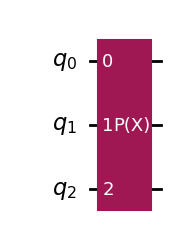

In [5]:
# view circuit 
uncertainty_model.draw('mpl')

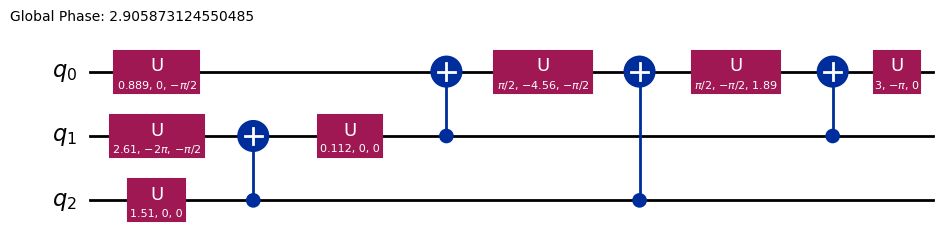

In [6]:
# view detailed circuit in terms of basis gates
uncertainty_model.decompose().decompose().decompose().draw("mpl")

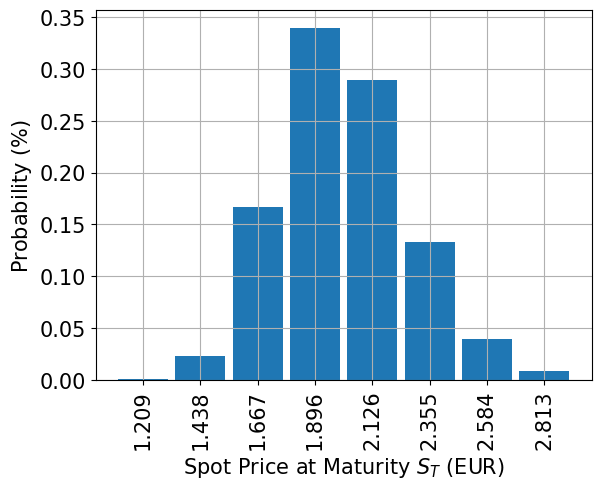

In [7]:
%matplotlib inline
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.figure()
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel(r"Spot Price at Maturity $S_T$ (EUR)", size=15)
plt.ylabel(r"Probability ($\%$)", size=15)
plt.show()

## Encoding the payoff function

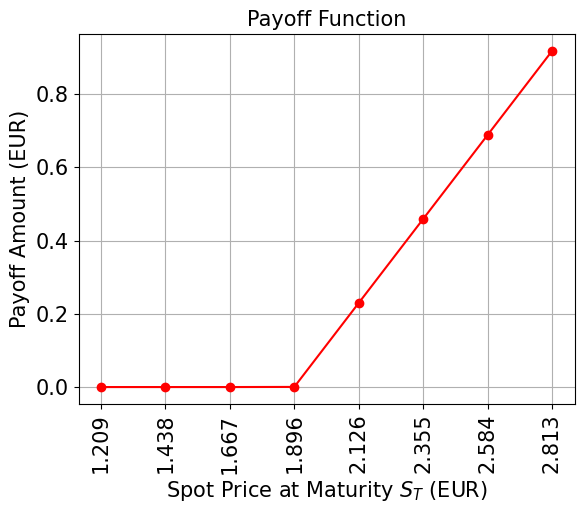

In [8]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.figure()
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel(r"Spot Price at Maturity $S_T$ (EUR)", size=15)
plt.ylabel("Payoff Amount (EUR)", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K$ and then increases linearly.
The implementation uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K$, and this ancilla is used to control the linear part of the payoff function.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit. Recall that

$$ \mathbb{P}(\textrm{measure 1}) = \mathbb{E}[f(X)] = \sum_{i=0}^{2^n-1}f(i)p_i.$$

For more details on the implementation, we refer to:

[LinearAmplitudeFunction | IBM Qiskit Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.LinearAmplitudeFunction)

In [9]:
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective function
breakpoints = [x_min, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = x_max - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(x_min, x_max),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)


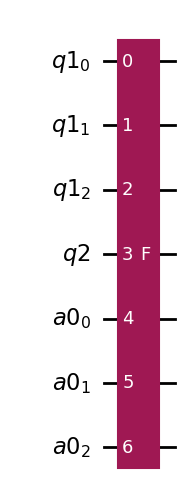

In [10]:
# view payoff function circuit
european_call_objective.draw('mpl')

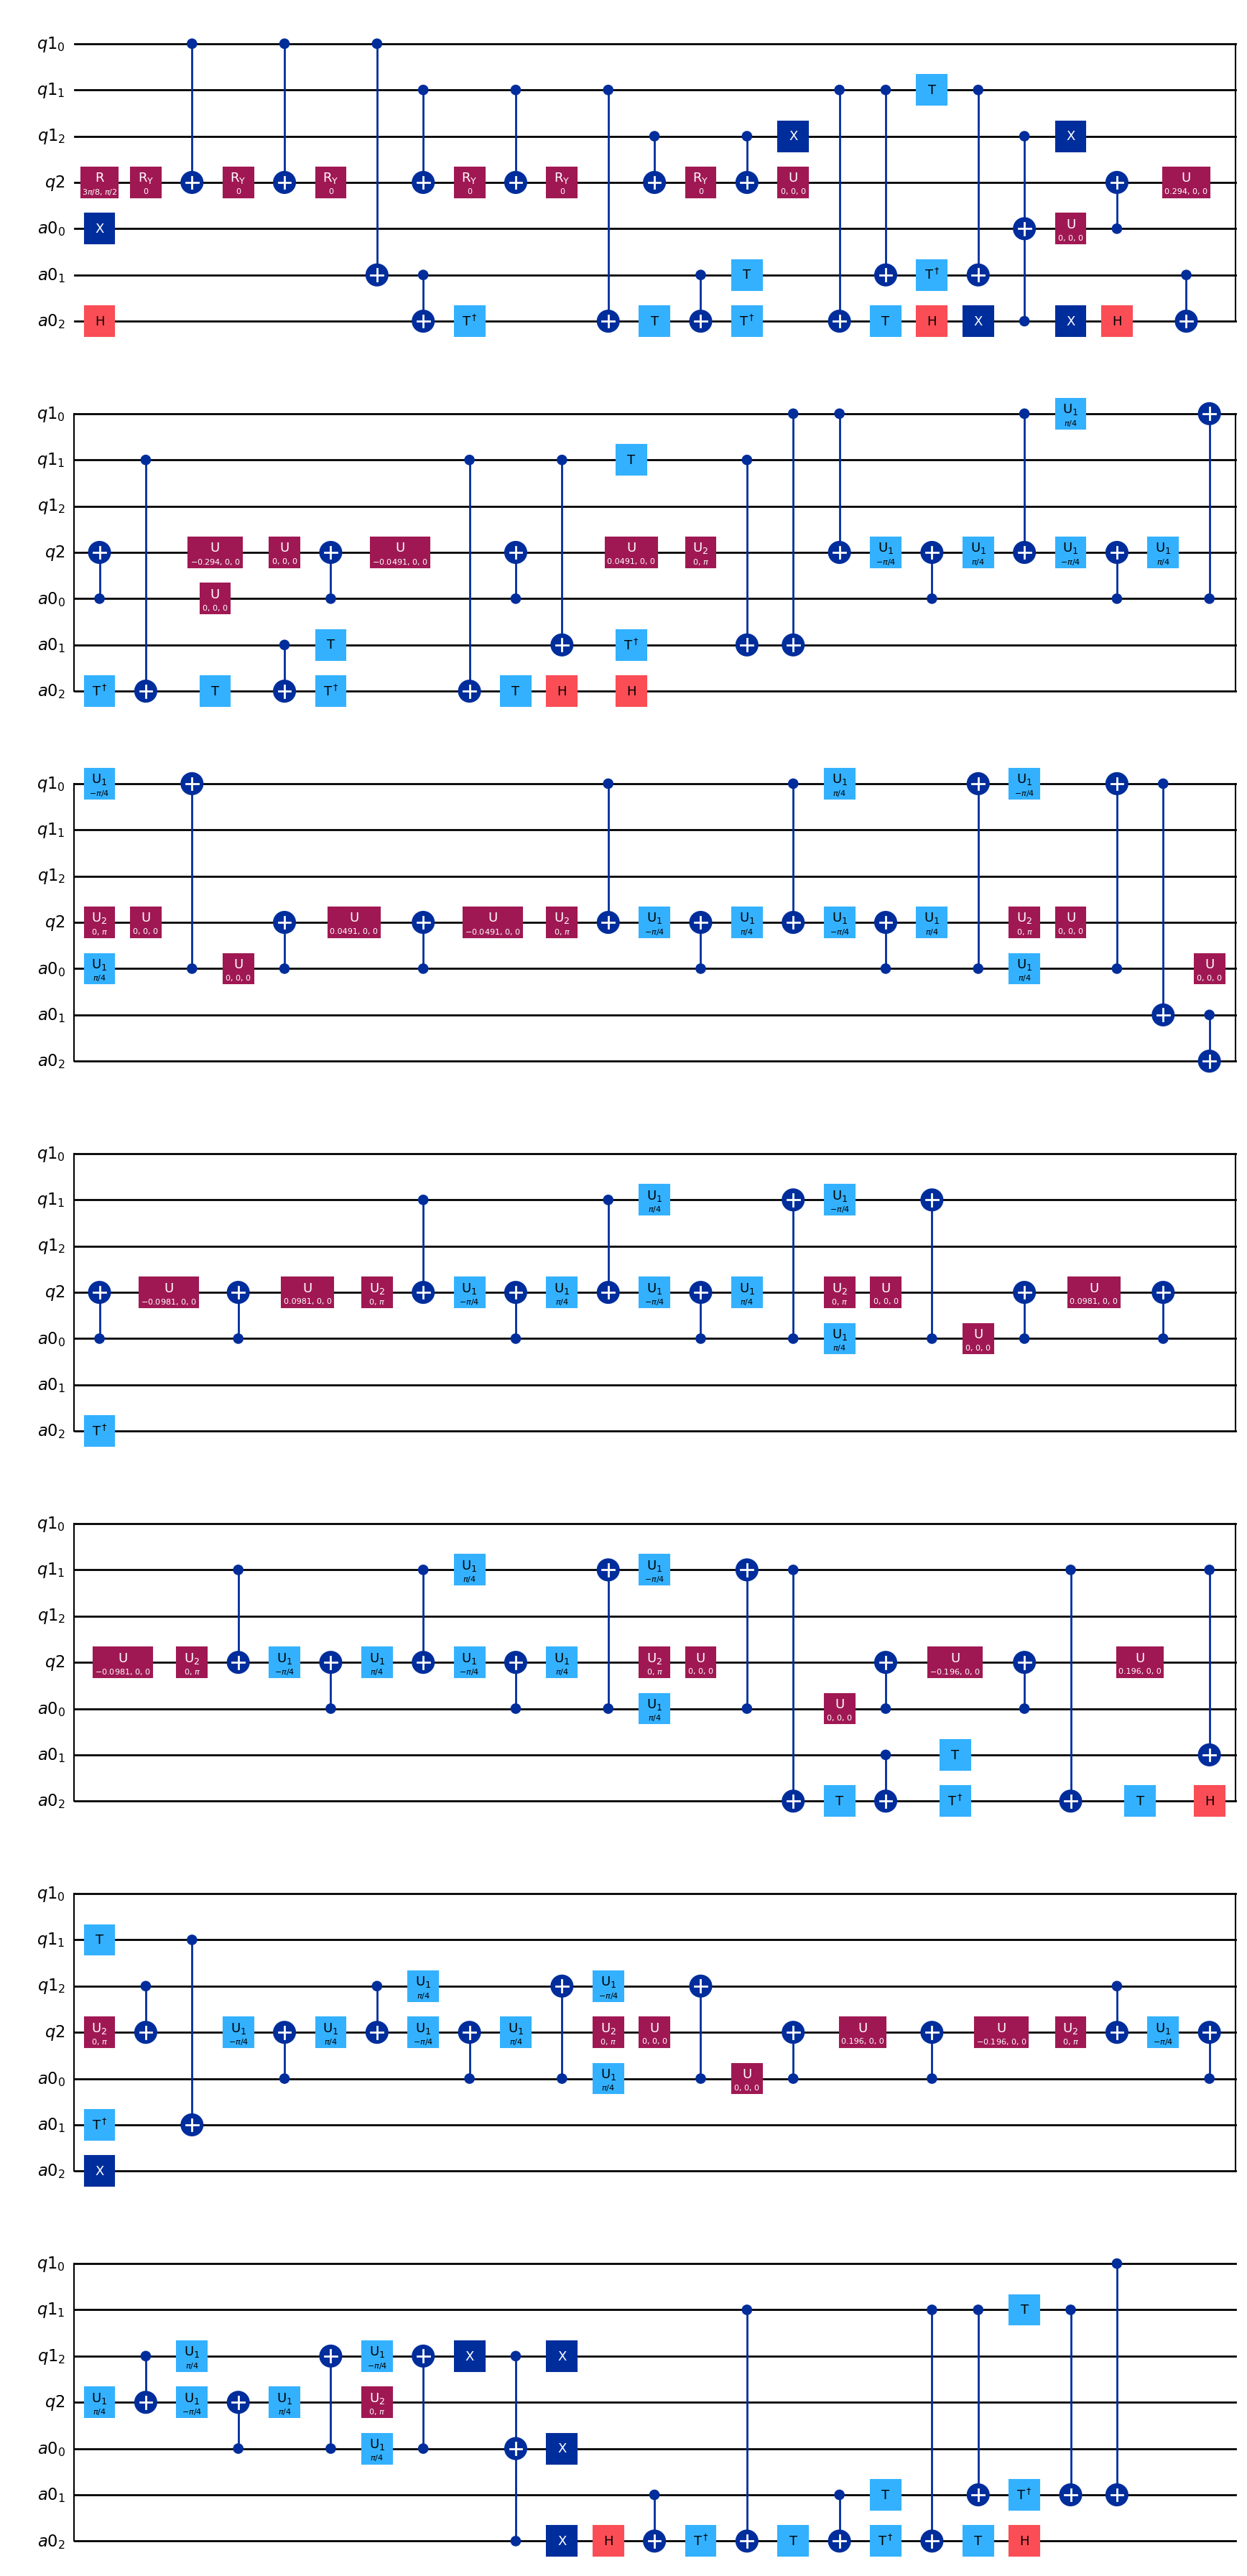

In [11]:
# view payoff function circuit
function_circuit = european_call_objective.decompose().decompose().decompose().decompose().decompose()
function_circuit.draw("mpl")

## Combining the distribution and payoff circuits

We combine the circuits for the underlying distribution and the payoff function, respectively. The $q$ qubit contains the expected value of the payoff. We add a measurement operator for $q$.

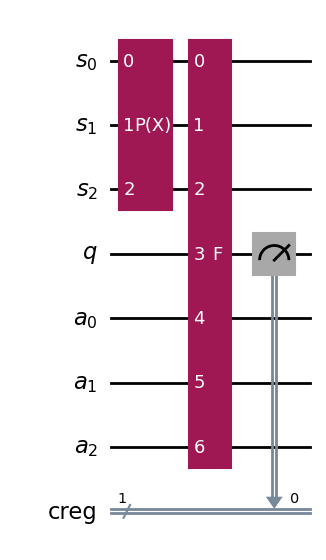

In [12]:
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
num_clbits = 1
qreg = QuantumRegister(num_uncertainty_qubits, 's')
qreg2 = QuantumRegister(1, 'q')
qreg3 = AncillaRegister(num_qubits-num_uncertainty_qubits-1, 'a')
creg = ClassicalRegister(num_clbits, 'creg')
european_call = QuantumCircuit(creg, qreg, qreg2, qreg3)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))
european_call.measure(qreg2, creg)

# draw the circuit
european_call.draw("mpl")

Next, we run the combined circuit and calculate the average $\hat p$. The average is scaled back from the $[0,1]$ interval to the original $[x_{min}, x_{max}]$ interval.

In [13]:
#run on local simulator
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()
n_shots = 10000
result = sampler.run([european_call], shots=n_shots).result()
#dir(result[0].data)
dist = result[0].data.creg.get_int_counts()

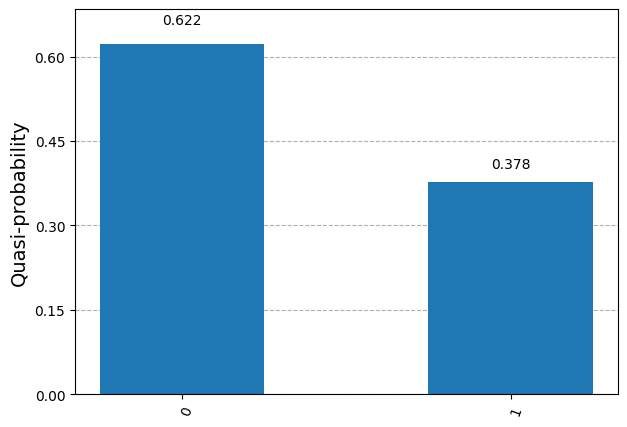

In [14]:
plot_distribution(dist)

In [15]:
p_hat = dist[1]/n_shots
p_std = np.sqrt(p_hat*(1-p_hat)/n_shots)

print("raw estimated average:\t%.4f" % p_hat, ", standard deviation:\t%.4f" % p_std)

expectation = european_call_objective.post_processing(p_hat)
upper = european_call_objective.post_processing(p_hat + 2*p_std)
lower = european_call_objective.post_processing(p_hat - 2*p_std)

print("estimation of expected payoff:\t%.4f" % expectation)
print("lower confidence bound:\t%.4f" % lower)
print("upper confidence bound:\t%.4f" % upper)

raw estimated average:	0.3779 , standard deviation:	0.0048
estimation of expected payoff:	0.1735
lower confidence bound:	0.1508
upper confidence bound:	0.1961


In [16]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
print("exact expected value from discretization:\t%.4f" % exact_value)

exact expected value from discretization:	0.1623
